In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")

print("Path to dataset files:", path)

100%|██████████| 1.15G/1.15G [00:09<00:00, 133MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7


In [2]:
import os

dataset_path = path
print("Main Folders:", os.listdir(dataset_path))

seg_data_path = os.path.join(dataset_path, 'Infection Segmentation Data', 'Infection Segmentation Data')

if os.path.exists(seg_data_path):
    print("Found Segmentation Data!")
    print("Subfolders:", os.listdir(seg_data_path))
else:
    print("Could not find the subfolder. Check the list above for the correct name.")

Main Folders: ['Lung Segmentation Data', 'Infection Segmentation Data', 'COVID-QU-Ex dataset.txt']
Found Segmentation Data!
Subfolders: ['Val', 'Test', 'Train']


count the class distribution

In [3]:
import os
import pandas as pd

seg_data_path = os.path.join(path, 'Infection Segmentation Data', 'Infection Segmentation Data')

splits = ['Train', 'Val', 'Test']
categories = ['COVID-19', 'Non-COVID', 'Normal']

data_counts = []

for split in splits:
    split_info = {'Split': split}
    for cat in categories:
        current_category_images_path = os.path.join(seg_data_path, split, cat, 'images')
        count = len(os.listdir(current_category_images_path))
        split_info[cat] = count
    data_counts.append(split_info)

df_counts = pd.DataFrame(data_counts)
print("--- Class Distribution ---")
print(df_counts)

--- Class Distribution ---
   Split  COVID-19  Non-COVID  Normal
0  Train      1864        932     932
1    Val       466        233     233
2   Test       583        292     291


checking img size

In [4]:
from PIL import Image

sample_path = os.path.join(seg_data_path, 'Train', 'COVID-19', 'images', 'covid_1.png')
with Image.open(sample_path) as img:
    width, height = img.size
    print(f"\nSample Image Resolution: {width}x{height}")
    print(f"Image Mode: {img.mode}")


Sample Image Resolution: 256x256
Image Mode: L


In [5]:
# Path to the COVID-19 directory within the Train split
covid_train_path = os.path.join(seg_data_path, 'Train', 'COVID-19')

print(f"Listing contents of: {covid_train_path}")

if os.path.exists(covid_train_path):
    print("Contents:", os.listdir(covid_train_path))
else:
    print(f"Directory does not exist: {covid_train_path}")

Listing contents of: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19
Contents: ['infection masks', 'lung masks', 'images']


get features

In [7]:
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier

img_dir = os.path.join(covid_train_path, 'images')
mask_dir = os.path.join(covid_train_path, 'infection masks')

def get_pixel_features(img):
    """Creates features for every pixel: Intensity, Blur, and Edges."""
    features = []
    features.append(img.flatten()) # Feature 1: Raw intensity

    # Feature 2: Gaussian Blur (Context)
    blur = cv2.GaussianBlur(img, (5, 5), 0).flatten()
    features.append(blur)

    # Feature 3: Sobel Filter (Edge detection for infection boundaries)
    sobel = cv2.Sobel(img, cv2.CV_8U, 1, 1, ksize=3).flatten()
    features.append(sobel)

    return np.array(features).T # Returns (Pixels x Features)

X_train = []
y_train = []

# 30 images to keep it fast
sample_files = sorted(os.listdir(img_dir))[:30]

print("Extracting features from 30 images...")
for file in sample_files:
    img = cv2.imread(os.path.join(img_dir, file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_dir, file), cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None:
        X_train.append(get_pixel_features(img))
        y_train.append((mask.flatten() > 0).astype(int)) # 1 if infection, 0 if background

# Combine all pixels into one giant table
X = np.vstack(X_train)
y = np.concatenate(y_train)

print(f"Feature matrix shape: {X.shape}")

Extracting features from 30 images...
Feature matrix shape: (1966080, 3)


In [8]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=12, n_jobs=-1, verbose=1)

print("Training Random Forest...")
rf_model.fit(X, y)
print("Training Complete!")

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min


Training Complete!


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


predict function

In [10]:
import matplotlib.pyplot as plt

def predict_mask(img_path, model):
    # 1. Load and extract features
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Could not load image from {img_path}. Please check the path and file integrity.")
        return None, None # Return None for both if image loading fails

    features = get_pixel_features(img)

    # 2. Predict (this returns a flat array of 0s and 1s)
    prediction = model.predict(features)

    # 3. Reshape back to the original image size
    mask_prediction = prediction.reshape(img.shape)

    return img, mask_prediction

# test set
test_covid_images_dir = os.path.join(seg_data_path, 'Test', 'COVID-19', 'images')

# List files to find a valid one
image_files = os.listdir(test_covid_images_dir)
image_files = sorted([f for f in image_files if f.endswith('.png')]) # Ensure we only get pngs and sort for consistency

if image_files:
    # Use the first image file found in the directory
    valid_test_img_name = image_files[0]
    test_img_path = os.path.join(test_covid_images_dir, valid_test_img_name)
    test_mask_path = os.path.join(seg_data_path, 'Test', 'COVID-19', 'infection masks', valid_test_img_name)

    print(f"Using test image: {test_img_path}")
    original, predicted = predict_mask(test_img_path, rf_model)
    if original is not None:
        ground_truth = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
        print("Prediction successful.")
    else:
        print("Prediction failed due to image loading error.")
else:
    print(f"No image files found in {test_covid_images_dir}")
    original, predicted, ground_truth = None, None, None # Set to None to avoid errors if no images are found.

Using test image: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images/covid_1579.png


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Prediction successful.


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished


In [18]:
def calculate_dice(pred, target):
    pred = (pred > 0).astype(np.float32)
    target = (target > 0).astype(np.float32)

    intersection = np.sum(pred * target)
    dice = (2. * intersection) / (np.sum(pred) + np.sum(target) + 1e-8)
    return dice

score = calculate_dice(predicted, ground_truth)
print(f"Dice Score for this sample: {score:.4f}")

Dice Score for this sample: 0.6360


In [19]:
print(f"Unique values in Prediction: {np.unique(predicted)}")
print(f"Unique values in Ground Truth: {np.unique(ground_truth)}")
print(f"Total predicted infection pixels: {np.sum(predicted > 0)}")
print(f"Total ground truth infection pixels: {np.sum(ground_truth > 0)}")

# Check if they are at least in the same ballpark
if np.sum(predicted > 0) == 0:
    print("CRITICAL: The model is predicting only background!")

Unique values in Prediction: [0 1]
Unique values in Ground Truth: [  0 255]
Total predicted infection pixels: 34837
Total ground truth infection pixels: 23932


updating for dice loss is 0.00

In [14]:
from sklearn.ensemble import RandomForestClassifier

# 1. Improved Model: Added 'balanced' class weights to fix the 0.0000 score
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# 2. Rerun the training
print("Training with balanced weights...")
rf_model.fit(X, y)

# 3. Predict on a test image again
original, predicted = predict_mask(test_img_path, rf_model)

# 4. Calculate the new Dice Score
new_score = calculate_dice(predicted, ground_truth)
print(f"New Dice Score: {new_score:.4f}")

Training with balanced weights...
New Dice Score: 0.6360


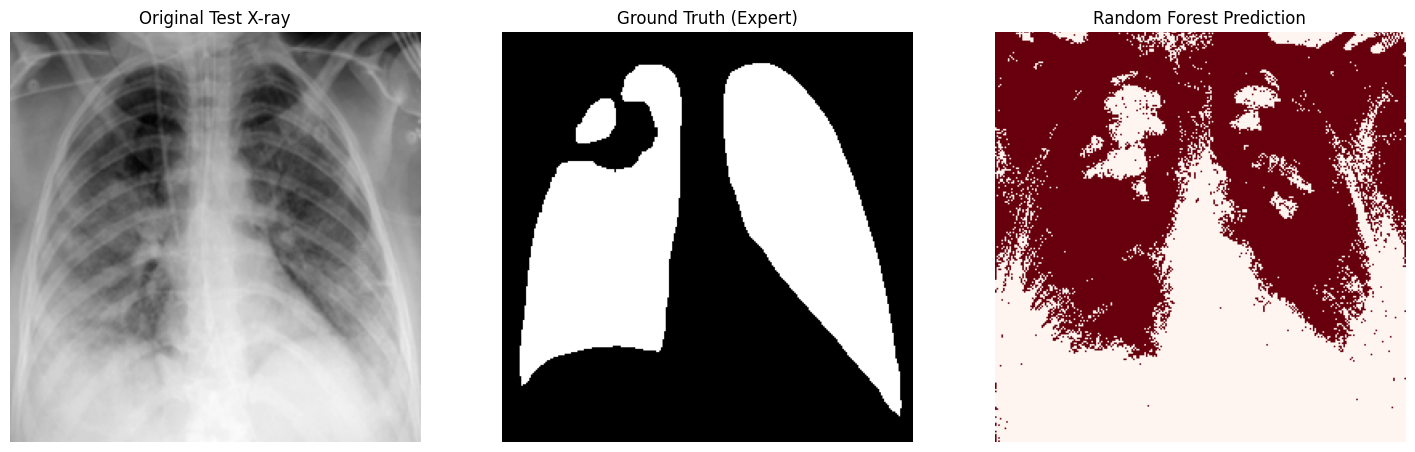

In [16]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Test X-ray")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth (Expert)")
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Random Forest Prediction")
plt.imshow(predicted, cmap='Reds') # Using Reds to highlight the predicted infection
plt.axis('off')

plt.show()

In [15]:
import pandas as pd

test_results = []
# Test on 10 random images from the test set
test_files = sorted(os.listdir(test_covid_images_dir))[10:20]

print("Evaluating on test samples...")
for file in test_files:
    t_path = os.path.join(test_covid_images_dir, file)
    m_path = os.path.join(seg_data_path, 'Test', 'COVID-19', 'infection masks', file)

    _, pred = predict_mask(t_path, rf_model)
    gt = cv2.imread(m_path, cv2.IMREAD_GRAYSCALE)

    score = calculate_dice(pred, gt)
    test_results.append({"File": file, "Dice Score": score})

df_results = pd.DataFrame(test_results)
avg_dice = df_results["Dice Score"].mean()

print(df_results)
print(f"\nAverage Dice Score: {avg_dice:.4f}")

Evaluating on test samples...
             File  Dice Score
0  covid_1595.png    0.455935
1  covid_1596.png    0.039258
2  covid_1597.png    0.684412
3  covid_1598.png    0.690935
4  covid_1600.png    0.026415
5  covid_1601.png    0.494163
6  covid_1602.png    0.457910
7  covid_1603.png    0.085306
8  covid_1604.png    0.246439
9  covid_1608.png    0.096203

Average Dice Score: 0.3277
